In [1]:
import sys
sys.path.append("..")
import credentials
import os

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook, tqdm
from sqlalchemy import create_engine
engine = create_engine(credentials.postgres)

In [4]:
# Basic Connection and Query
connection = engine.connect()

# Cache Strokes

In [9]:
force = True
if force:
    df = pd.read_sql_query("SELECT * FROM strokes WHERE user_id='3b57c0d9-2b14-4ec2-8b29-ad4e94811962' ORDER BY key_time", engine)
else:
    try: 
        df = pd.read_csv('output/strokes.csv').sort_values('key_time')
    except:
        df = pd.read_sql_query('SELECT * FROM strokes ORDER BY key_time', engine)

## Cache Each User

In [10]:
def process_user(user_strokes):
    # -------------
    # Output Strokes
    # -------------
    user = user_strokes.user_id.iloc[0]
    user_directory = 'output/users/{0}'.format(user)
    if not os.path.exists(user_directory):
        os.makedirs(user_directory)
    user_strokes.drop('user_id', 1).to_csv('{0}/strokes.csv'.format(user_directory), index=False)
    # -------------
    # Output dwells
    # -------------
    dwells = pd.DataFrame()
    for key, strokes in user_strokes.groupby('key_code'):
        # Eliminate non duplicate strokes
        strokes = strokes.loc[(strokes.direction != strokes.direction.shift(1))]
        # Split up and down actions
        down = strokes.loc[strokes.direction == 'd'].reset_index(drop=True)
        up = strokes.loc[strokes.direction == 'u'].reset_index(drop=True)
        # Filter non-matching strokes
        number = np.min([down.count(), up.count()])
        down = down.head(number)
        up = up.head(number)
        # Add to DataFrame
        dwells = dwells.append(pd.DataFrame({
            'key_code': key,
            'down': down.key_time,
            'up': up.key_time,
            'dwell': up.key_time - down.key_time
        }), ignore_index=True)
    # Output user's dwells to csv
    dwells = dwells.sort_values('down')[['key_code', 'down', 'up', 'dwell']].reset_index(drop=True)
    dwells.to_csv('{0}/dwells.csv'.format(user_directory), index=False)
    # -------------
    # Output flights
    # -------------
    flights = pd.DataFrame({
        'key_orig': dwells.key_code,
        'key_dest': dwells.shift(-1).key_code,
        'orig_down': dwells.down,
        'orig_up': dwells.up,
        'dest_down': dwells.shift(-1).down,
        'dest_up': dwells.shift(-1).up,
        'interval': dwells.shift(-1).down - dwells.up,
        'down_to_down': dwells.shift(-1).down - dwells.down,
        'up_to_up': dwells.shift(-1).up - dwells.up,
        'duration': dwells.shift(-1).up - dwells.down
    }).sort_values('orig_down')[['key_orig', 'key_dest', 'orig_down', 'orig_up', 'dest_down', 'dest_up', 'interval', 'down_to_down', 'up_to_up', 'duration']].reset_index(drop=True)
    flights.to_csv('{0}/flights.csv'.format(user_directory), index=False)
    # Prepare to return
    dwells['user_id'] = user
    flights['user_id'] = user
    return pd.Series({'dwells': dwells, 'flights': flights})

def process(strokes):
    try:
        get_ipython
        tqdm_notebook().pandas(desc="Loading Data")
    except:
        twdm().pandas(desc="Loading Data")
    results = strokes.groupby('user_id').progress_apply(process_user)
    dwells = pd.concat([i for i in results.dwells], ignore_index=False).sort_values('down')
    flights = pd.concat([i for i in results.flights], ignore_index=False).sort_values('orig_down')
    return pd.Series({'dwells': dwells, 'flights': flights})

In [18]:
user_strokes = df
user = user_strokes.user_id.iloc[0]
# -------------
# Output dwells
# -------------
dwells = pd.DataFrame()
for key, strokes in user_strokes.groupby('key_code'):
    # Eliminate non duplicate strokes
    strokes = strokes.loc[(strokes.direction != strokes.direction.shift(1))]
    # Split up and down actions
    down = strokes.loc[strokes.direction == 'd'].reset_index(drop=True)
    up = strokes.loc[strokes.direction == 'u'].reset_index(drop=True)
    # Filter non-matching strokes
    number = np.min([down.count(), up.count()])
    down = down.head(number)
    up = up.head(number)
    # Add to DataFrame
    dwells = dwells.append(pd.DataFrame({
        'key_code': key,
        'down': down.key_time,
        'up': up.key_time,
        'dwell': up.key_time - down.key_time
    }), ignore_index=True)
# Output user's dwells to csv
dwells = dwells.sort_values('down')[['key_code', 'down', 'up', 'dwell']].reset_index(drop=True)

In [13]:
results = process(df)

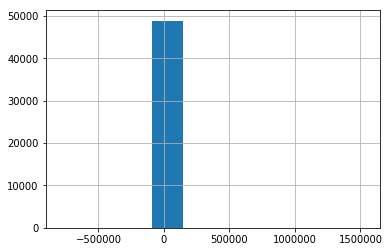

In [14]:
results.dwells.dwell.hist()